In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import stats
from astropy.stats import LombScargle
from astropy.time import Time
from joblib import Parallel, delayed

In [2]:
train_ts = pd.read_csv("../data/input/training_set.csv")
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
display(train_ts.head())

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [15]:
def get_divided_point(obj_data, thres_dist=100):
    obj_data = obj_data.sort_values('mjd', ascending=True)
    diff_mjd = obj_data.groupby('object_id')[['mjd']].diff()
    points = obj_data[diff_mjd > thres_dist]["mjd"].dropna().values
    points = np.concatenate([points, np.array([obj_data["mjd"].max()+1])])
    points = np.concatenate([np.array([obj_data["mjd"].min()-1]), points])
    
    result = []
    for i in range(len(points) - 1):
        result.append((points[i], points[i+1]))

    return result

def get_maxpoint(obj_data, thres_dict=100):
    points = get_divided_point(obj_data, thres_dict)

    max_result = []
    for point in points:
        max_value = obj_data.query('mjd >= @point[0] & mjd < @point[1]')["flux"].max()
        if max_value != max_value:
            max_value = 0
        max_result.append(max_value)

    max_point = points[np.argmax(max_result)]
    return obj_data.query('mjd >= @max_point[0] & mjd < @max_point[1]')

def add_maxpoint(ts_data, meta_data):
    object_id_list = ts_data.object_id.unique().tolist()
    results = Parallel(n_jobs=-1)(
        [delayed(get_maxpoint)(ts_data.query('object_id == @object_id')) for object_id in object_id_list])
    ts_data = pd.concat(results, axis=0, ignore_index=True)
    return ts_data

In [4]:
add_ts = add_maxpoint(train_ts, train_meta)

In [5]:
add_ts.object_id.unique().shape

(7848,)

[(59619.2326, 59946.3589), (59946.3589, 60334.2886), (60334.2886, 60666.3563), (60666.3563, 60667.3563)]


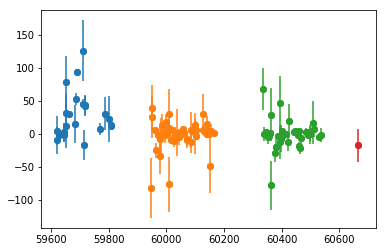

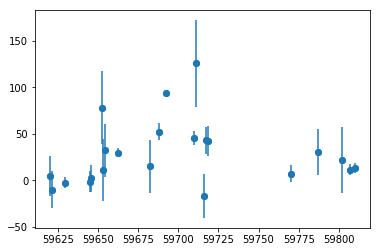

In [16]:
sample = train_ts.query('object_id == 109477227')
maxpoint = get_maxpoint(sample)
points = get_divided_point(sample)
print(points)

for point in points:
    extract = sample.query('mjd >= @point[0] & mjd < @point[1]')
    t = extract["mjd"]
    y = extract["flux"]
    y_err = extract["flux_err"]
    plt.scatter(t, y)
    plt.errorbar(t, y, y_err, fmt="o")
plt.show()

t = maxpoint["mjd"]
y = maxpoint["flux"]
y_err = maxpoint["flux_err"]
plt.scatter(t, y)
plt.errorbar(t, y, y_err, fmt="o")
plt.show()

[(59619.2326, 59946.3589), (59946.3589, 60334.2886), (60334.2886, 60666.3563), (60666.3563, 60667.3563)]


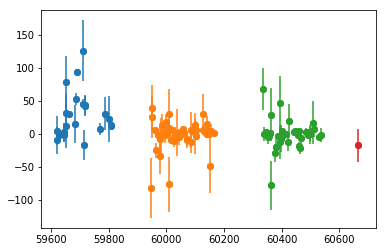

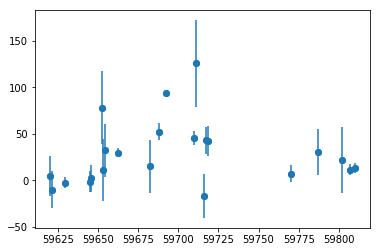

In [17]:
sample = train_ts.query('object_id == 109477227')
maxpoint = get_maxpoint(sample)
points = get_divided_point(sample)
print(points)

for point in points:
    extract = sample.query('mjd >= @point[0] & mjd < @point[1]')
    t = extract["mjd"]
    y = extract["flux"]
    y_err = extract["flux_err"]
    plt.scatter(t, y)
    plt.errorbar(t, y, y_err, fmt="o")
plt.show()

t = maxpoint["mjd"]
y = maxpoint["flux"]
y_err = maxpoint["flux_err"]
plt.scatter(t, y)
plt.errorbar(t, y, y_err, fmt="o")
plt.show()